In [ ]:
import os
from collections import Counter

print("hello world")


# Rnn Architecture implementation 



In [5]:
import torch 
import torch.nn as nn
import  torchvision 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import PIL
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime
from utils import *

In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device : {device}")

Device : cpu


In [12]:
!unzip *.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [17]:
import unicodedata 
import string 
import os


In [15]:
all_letters=string.ascii_letters +".,;"
n_letters=len(all_letters)

print(f"n_letters: {n_letters}")

n_letters: 53


In [18]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c)!='Mn' and  c in all_letters
    )

In [20]:
all_names=[]
all_countries=[]

In [23]:
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [32]:
import torch
from torch.utils.data import Dataset
from io import open
import glob 
import time 

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item


data_dir= ""
dataset = NamesDataset(data_dir)

print(f"Dataset Size: {len(dataset)}")
print(f"data: {dataset.data[:5]}")
print(f"labels: {dataset.labels[:5]}")
alldata=NamesDataset("data/names")


Dataset Size: 20074
data: ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
labels: ['Czech', 'Czech', 'Czech', 'Czech', 'Czech']


In [33]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")


train examples = 17063, validation examples = 3011


In [56]:
import torch.nn.functional as F

class CharRnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRnn, self).__init__()
        self.rnn=nn.RNN(input_size, hidden_size)
        self.h2o=nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        out = self.h2o(hidden[0])
        out = self.softmax(out)
        return out
    
    
        
        
        
        
        

In [57]:
n_hidden=128
rnn=CharRnn(n_letters,n_hidden,len(alldata.labels_uniq))
print(rnn)

CharRnn(
  (rnn): RNN(53, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [58]:
output = rnn(input)  # Extract only the output (ignore hidden state)


In [60]:
#labeling from output 

def label_f_output(output,output_labels):
    top_n,top_i=torch.topk(output,1)
    label_i=top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_f_output(output, alldata.labels_uniq))

tensor([[-2.9459, -2.8119, -2.8841, -2.9732, -2.8089, -2.9635, -2.8880, -2.9372,
         -2.8239, -2.9160, -3.0045, -2.8262, -2.8316, -2.8125, -2.8445, -2.8631,
         -2.9603, -2.9693]], grad_fn=<LogSoftmaxBackward0>)
('French', 4)


In [61]:
import torch
import random
import numpy as np
import time

def train(rnn, training_data, n_epoch=10, n_batch_size=64, report_every=50, learning_rate=0.2, criterion=torch.nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds.
    """
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()  # clear the gradients

        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:  # for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

          
        
        
        

In [62]:
start=time.time()
all_losses = train(rnn,train_set,n_epoch=27,learning_rate=0.15,report_every=5)
end = time.time()
print(f"Training took {end-start}")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8843151692212696
10 (37%): 	 average batch loss = 0.6947510282934023
15 (56%): 	 average batch loss = 0.5841308258926337
20 (74%): 	 average batch loss = 0.5033643579891544
25 (93%): 	 average batch loss = 0.43991632600648334
Training took 135.12282490730286


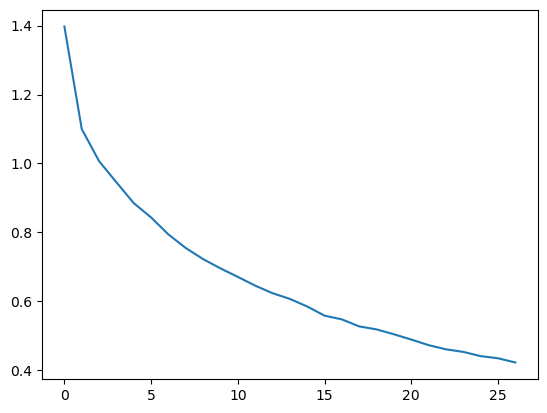

In [63]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

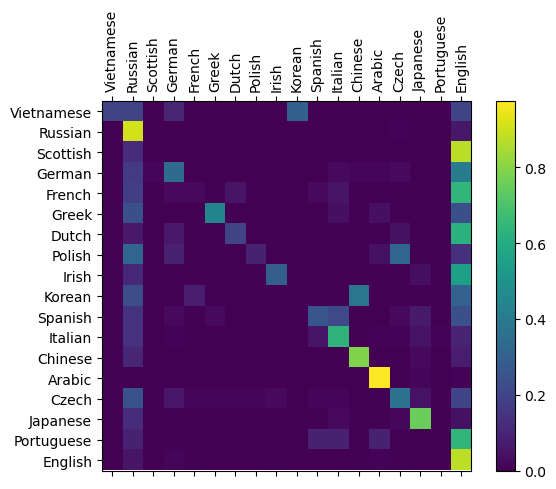

In [65]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_f_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)